# Naive Bayes

In [28]:
# Import packages
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

In [33]:
# Read dataset
data_raw = pd.read_csv("data_raw.csv")


# Basic cleaning
data_clean = data_raw.replace("#NAME?", "")
data_clean = data_clean.fillna("")
data_clean.columns = ["id", "t1", "n1", "c1", "n2", "c2", "t2", "n3", "n4", "t3", "label"]

data_vec = data_clean[["id"]].copy()


# Vectorize `choice` columns
option = ["computation", "code", "analysis", "concept", "format", "essay", "text", "idea"]

for i in range(1, 3):
    for opt in option:
        data_vec[f"c{i}_{opt}"] = data_clean[f"c{1}"].str.contains(opt).astype(int)


# Vectorize `text` columns
for i in range(1, 4):
    vec = CountVectorizer(max_features=3000, binary=True)
    t_mat = vec.fit_transform(data_clean[f"t{i}"])
    
    col = []
    for word in vec.get_feature_names_out():
        col.append(f"t{i}_{word}")
    data_t = pd.DataFrame(t_mat.toarray(), columns=col)
    data_vec = pd.concat([data_vec, data_t], axis=1)


# Categorize `label` column
data_vec["label"] = pd.factorize(data_clean["label"])[0]


# Write cleaned dataset to .csv file
data_vec.to_csv("data_vec.csv", index=False)


# Split data (68%-16%-16%)
stud = data_vec["id"].unique().tolist()
random.shuffle(stud)
train, valid, test = stud[:187], stud[187:231], stud[231:]

data_train = data_vec[data_vec["id"].isin(train)]
data_valid = data_vec[data_vec["id"].isin(valid)]
data_test = data_vec[data_vec["id"].isin(test)]

X_train, t_train = data_train.drop(["id", "label"], axis=1).values, data_train["label"].values
X_valid, t_valid = data_valid.drop(["id", "label"], axis=1).values, data_valid["label"].values
X_test, t_test = data_test.drop(["id", "label"], axis=1).values, data_test["label"].values

In [23]:
# Training
def nb_map3(X, t, a, b):
    N, pi, N_t, theta = X.shape[0], np.zeros(3), np.zeros(3), np.zeros([X.shape[1], 3])
    
    for i in range(3):
        N_i, X_i = np.sum(t == i), X[t == i]
        N_t[i] = N_i
        pi[i] = (a + N_i - 1) / (a + b + N - 2)
        theta[:, i] = (a + np.sum(X_i, axis=0) - 1) / (a + b + X_i.shape[0] - 2)
    
    return pi, theta


# Prediction
def pred3(X, pi, theta):
    log_p = np.zeros((X.shape[0], 3))
    for i in range(3):
        log_p[:, i] = np.log(pi[i]) + X @ np.log(theta[:, i]) + (1 - X) @ np.log(1 - theta[:, i])

    return np.argmax(log_p, axis=1)


# Accuracy
def acc(y, t):
    return np.mean(y == t)

# Plot
def plot_acc(acc_mat, values, title):
    plt.figure(figsize=(12, 10))
    plt.imshow(acc_mat, cmap="RdYlGn")
    
    for i in range(len(values)):
        for j in range(len(values)):
            plt.text(j, i, f"{acc_mat[i, j]:.3f}", ha="center", va="center")
    
    plt.xticks(range(len(values)), values)
    plt.yticks(range(len(values)), values)
    plt.xlabel("b")
    plt.ylabel("a")
    plt.title(title)
    plt.colorbar()
    plt.show()

In [20]:
# Hyperparameter tuning
values = [1.1, 1.2, 1.3, 1.4, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0, 5.0, 7.5, 10.0]
n = len(values)
acc_train, acc_valid = np.zeros((n, n)), np.zeros((n, n))

for i in range(n):
    for j in range(n):
        pi, theta = nb_map3(X_train, t_train, values[i], values[j])
        y_train = pred3(X_train, pi, theta)
        acc_train[i, j] = acc(y_train, t_train)
        y_valid = pred3(X_valid, pi, theta)
        acc_valid[i, j] = acc(y_valid, t_valid)

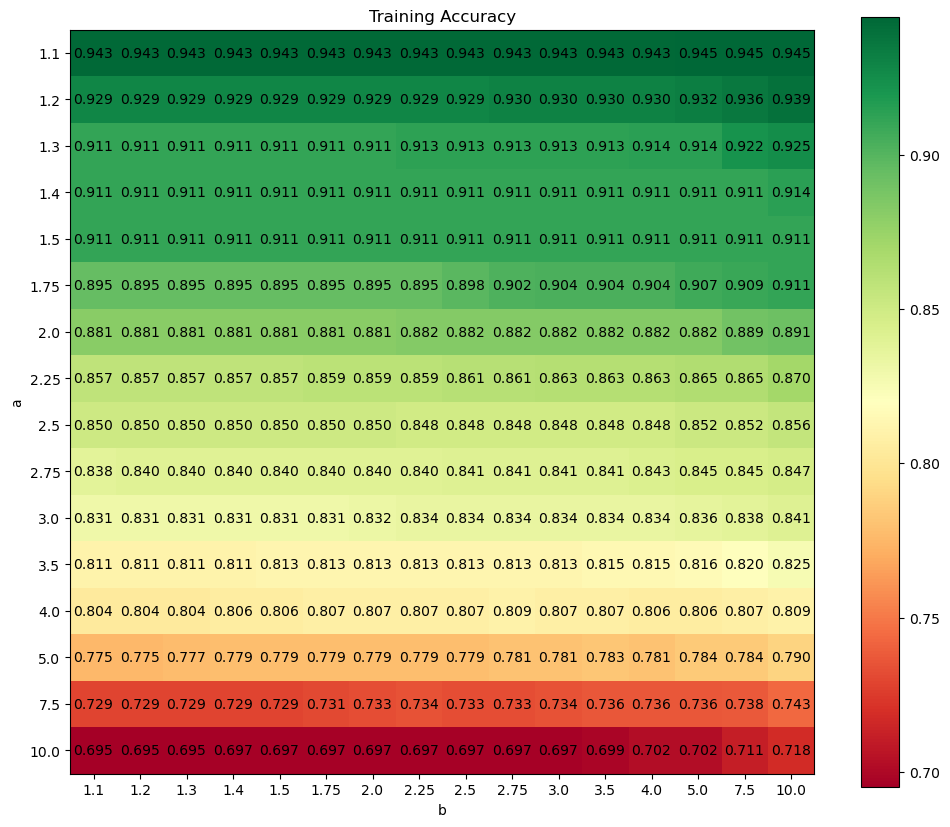

In [24]:
# Plot training accuracy
plot_acc(acc_train, values, "Training Accuracy")

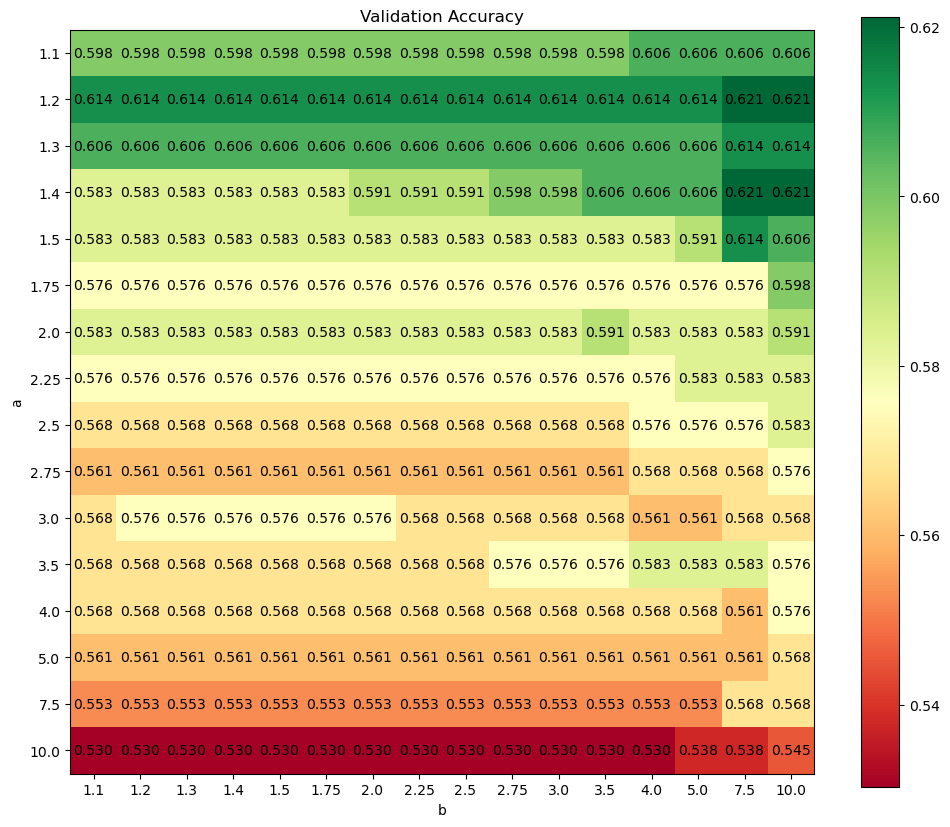

In [25]:
# Plot validation accuracy
plot_acc(acc_valid, values, "Validation Accuracy")

In [26]:
# Testing
a_opt, b_opt = 1.2, 10.0
pi, theta = nb_map3(X_train, t_train, a_opt, b_opt)
y_test = pred3(X_test, pi, theta)
acc_test = acc(y_test, t_test)
acc_test

np.float64(0.5757575757575758)

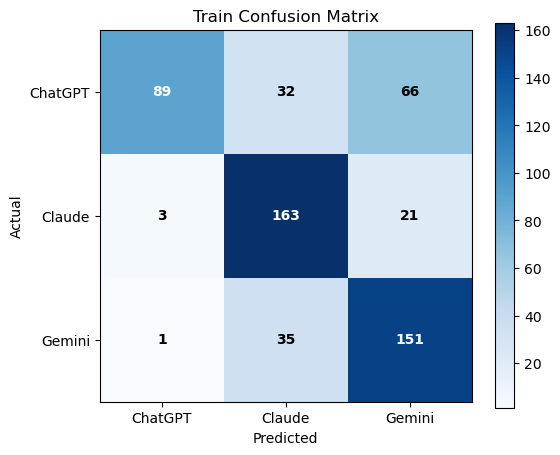

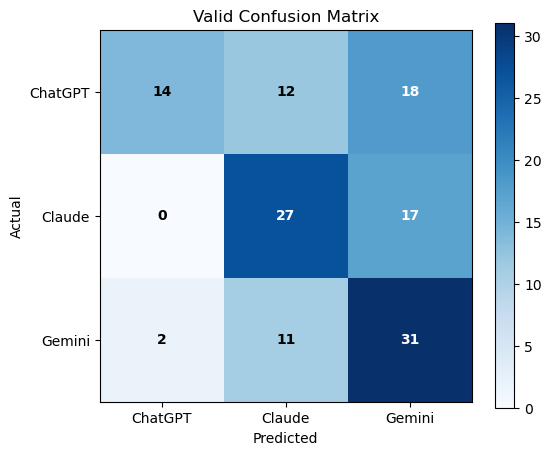

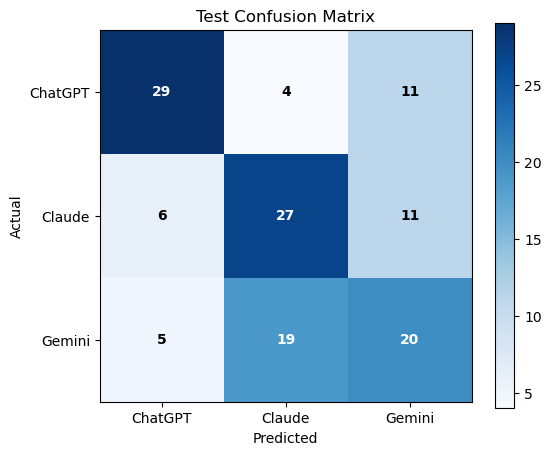

In [35]:
def plot_confusion(cm, classes, title):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap="Blues")
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, f"{cm[i, j]}", ha="center", va="center", 
                    fontweight="bold", color="white" if cm[i, j] > cm.max()/2 else "black")
    
    plt.xticks(range(len(classes)), classes)
    plt.yticks(range(len(classes)), classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.colorbar()
    plt.show()

class_names = ["ChatGPT", "Claude", "Gemini"]
plot_confusion(confusion_matrix(t_train, y_train), class_names, "Training Confusion Matrix")
plot_confusion(confusion_matrix(t_valid, y_valid), class_names, "Validation Confusion Matrix") 
plot_confusion(confusion_matrix(t_test, y_test), class_names, "Testing Confusion Matrix")